# Modelo LightGBM para Predicción de Prima de Seguro Médico

Este cuaderno implementa un flujo de trabajo completo de aprendizaje automático para predecir la variable **"prima_out_of_pocket_editada"** utilizando un modelo LightGBM. El flujo incluye:

- Carga y preprocesamiento de datos
- Ingeniería de características
- Entrenamiento y evaluación del modelo
- Visualización de curvas de aprendizaje e importancia de variables
- Guardado del modelo entrenado
- Búsqueda de hiperparámetros

In [8]:
# Carga de datos y preprocesamiento
import pandas as pd
from sklearn.model_selection import train_test_split

# Cargar el conjunto de datos plano
print("Cargando el conjunto de datos...")
df = pd.read_csv('../snapshots_flat.csv')

# Identificar columnas categóricas
columnas_categoricas = df.select_dtypes(include=['object', 'category']).columns.tolist()
print(f"Columnas categóricas detectadas: {columnas_categoricas}")

# Aplicar one-hot encoding a las variables categóricas
if columnas_categoricas:
    df = pd.get_dummies(df, columns=columnas_categoricas, drop_first=True)
    print("One-hot encoding aplicado a variables categóricas.")
else:
    print("No se detectaron columnas categóricas.")

# Definir variables predictoras y objetivo
X = df.drop('prima_out_of_pocket_editada', axis=1)
y = df['prima_out_of_pocket_editada']

# Dividir en conjuntos de entrenamiento y prueba
print("Dividiendo los datos en entrenamiento y prueba...")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Tamaño de entrenamiento: {X_train.shape}, Tamaño de prueba: {X_test.shape}")

Cargando el conjunto de datos...
Columnas categóricas detectadas: ['sexo', 'raza_etnicidad', 'estado_civil', 'region', 'categoria_pobreza', 'cobertura_seguro', 'estado_salud_percibido', 'cobertura_seguro_detallada']
One-hot encoding aplicado a variables categóricas.
Dividiendo los datos en entrenamiento y prueba...
Tamaño de entrenamiento: (9481, 48), Tamaño de prueba: (2371, 48)


Entrenando el modelo LightGBM...
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000864 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1565
[LightGBM] [Info] Number of data points in the train set: 9481, number of used features: 47
[LightGBM] [Info] Start training from score 306.363963
Realizando predicciones...
MSE: 37755.70
MAE: 80.28
R2: 0.66
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000294 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1405
[LightGBM] [Info] Number of data points in the train set: 948, number of used features: 40
[LightGBM] [Info] Start training from score 304.907046
[LightGBM] [Warning] Found whitespace in feature_names, repla

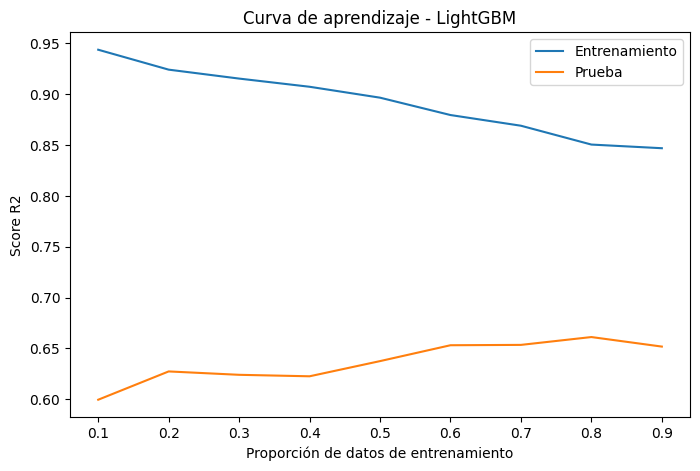

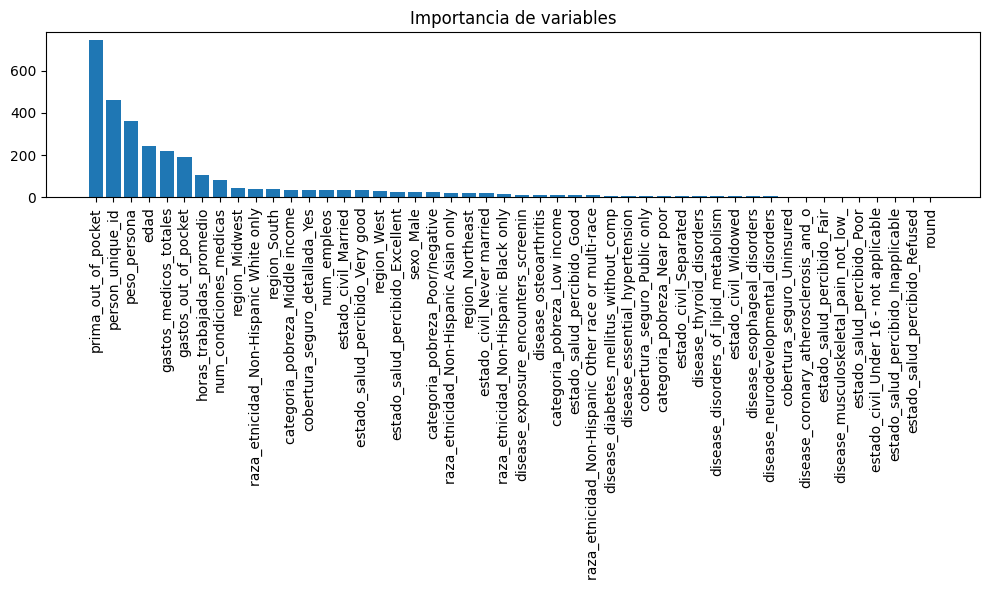

Modelo guardado en output/lightgbm_model.joblib


In [9]:
# Entrenamiento, evaluación y visualización del modelo
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import numpy as np
import joblib

# Entrenar el modelo
print("Entrenando el modelo LightGBM...")
lgbm = LGBMRegressor(n_estimators=100, random_state=42)
lgbm.fit(X_train, y_train)

# Predicciones
print("Realizando predicciones...")
y_pred = lgbm.predict(X_test)

# Evaluación
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"MSE: {mse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R2: {r2:.2f}")

# Curva de aprendizaje
train_scores = []
test_scores = []
sizes = np.linspace(0.1, 0.9, 9)  # Evitar 1.0
for size in sizes:
    X_train_part, _, y_train_part, _ = train_test_split(X_train, y_train, train_size=size, random_state=42)
    lgbm_part = LGBMRegressor(n_estimators=100, random_state=42)
    lgbm_part.fit(X_train_part, y_train_part)
    train_scores.append(lgbm_part.score(X_train_part, y_train_part))
    test_scores.append(lgbm_part.score(X_test, y_test))

plt.figure(figsize=(8,5))
plt.plot(sizes, train_scores, label='Entrenamiento')
plt.plot(sizes, test_scores, label='Prueba')
plt.xlabel('Proporción de datos de entrenamiento')
plt.ylabel('Score R2')
plt.title('Curva de aprendizaje - LightGBM')
plt.legend()
plt.show()

# Importancia de variables
importancias = lgbm.feature_importances_
indices = np.argsort(importancias)[::-1]
plt.figure(figsize=(10,6))
plt.title('Importancia de variables')
plt.bar(range(X.shape[1]), importancias[indices])
plt.xticks(range(X.shape[1]), X.columns[indices], rotation=90)
plt.tight_layout()
plt.show()

# Guardar el modelo
joblib.dump(lgbm, 'output/lightgbm_model.joblib')
print("Modelo guardado en output/lightgbm_model.joblib")

In [10]:
# Búsqueda de hiperparámetros
from sklearn.model_selection import GridSearchCV
from lightgbm import LGBMRegressor
import joblib

print("Iniciando búsqueda de hiperparámetros...")
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 6, 10],
    'learning_rate': [0.01, 0.1, 0.2]
}
grid = GridSearchCV(LGBMRegressor(random_state=42), param_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
grid.fit(X_train, y_train)

print(f"Mejores parámetros: {grid.best_params_}")
print(f"Mejor puntuación (MSE negativo): {grid.best_score_}")

# Guardar el mejor modelo
joblib.dump(grid.best_estimator_, 'output/lightgbm_best_model.joblib')
print("Mejor modelo guardado en output/lightgbm_best_model.joblib")

# Resumen de mejores hiperparámetros
print("\nResumen de mejores hiperparámetros:")
print(grid.best_params_)

# Evaluación general del modelo
if grid.best_score_ > -1:
    print("Advertencia: El error de validación cruzada es muy bajo, posible overfitting.")
elif grid.best_score_ < -1000:
    print("Advertencia: El error de validación cruzada es muy alto, posible underfitting o mala calidad de datos.")
else:
    print("El modelo presenta un desempeño razonable según la métrica de validación cruzada.")

Iniciando búsqueda de hiperparámetros...
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000346 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1565
[LightGBM] [Info] Number of data points in the train set: 9481, number of used features: 47
[LightGBM] [Info] Start training from score 306.363963
Mejores parámetros: {'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 100}
Mejor puntuación (MSE negativo): -35180.23551637225
Mejor modelo guardado en output/lightgbm_best_model.joblib

Resumen de mejores hiperparámetros:
{'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 100}
Advertencia: El error de validación cruzada es muy alto, posible underfitting o mala calidad de datos.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines